## 1. 텐서플로우 메모리 관리

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

2022-08-02 21:53:00.840501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 21:53:00.941253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 21:53:00.943186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## 2. 패키지 로드

In [2]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, MaxPool2D
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
from PIL import Image
import cv2
from glob import glob
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## 3. 데이터 로드

In [3]:
# 데이터 로드
human_image_datas = glob('./image_human/*.jpg')
webtoon_image_datas = glob('./image_webtoon/*.jpg')

In [4]:
# 데이터 크기 확인
len(human_image_datas), len(webtoon_image_datas)

(10456, 27702)

In [5]:
# 데이터 셋으로 합치기
data_set = [human_image_datas, webtoon_image_datas[:10456]]
X = []

for data in tqdm(data_set):
    for image_name in tqdm(data):
        image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (32, 32))
        ret, thres = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
        image = cv2.cvtColor(thres, cv2.COLOR_GRAY2RGB)
        X.append(image)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10456 [00:00<?, ?it/s]

  0%|          | 0/10456 [00:00<?, ?it/s]

In [6]:
X = np.array(X)

In [7]:
train_images, test_images = train_test_split(X, test_size=0.2, shuffle=True, random_state = 41)

In [8]:
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

In [9]:
train_images.shape, test_images.shape

((16729, 32, 32, 3), (4183, 32, 32, 3))

In [10]:
learning_rate = 0.01
epochs = 1000
batch_size = 32
latent_dim = 64

In [11]:
class AutoEncoder(Model):
    def __init__(self, latent_dim):
        super(AutoEncoder, self).__init__()
        
        self.latent_dim = latent_dim
        # 인코더 정의
        self.encoder = tf.keras.Sequential([
            Flatten(),
            Dense(latent_dim, activation='relu')
        ])
        
        self.decoder = tf.keras.Sequential([
            Dense(32 * 32 * 3, activation='sigmoid'),
            Reshape((32, 32, 3))
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [12]:
autoEncoder = AutoEncoder(latent_dim)
autoEncoder.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mse'])
checkpointer = ModelCheckpoint(filepath='./autoencoder.h5', verbos=1, save_best_only=True, save_weights_only=True, monitor='val_mse', mode='min')
earlystopping = EarlyStopping(monitor='val_mse', mode='min', verbose=1, patience=20)

2022-08-02 21:55:41.126786: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-02 21:55:41.127782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 21:55:41.130033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 21:55:41.132400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, 

In [13]:
history = autoEncoder.fit(train_images, train_images,
                epochs=epochs,
                shuffle=True,
                validation_data=(test_images, test_images), workers=2, callbacks=[checkpointer, earlystopping], batch_size=batch_size)

Epoch 1/1000
523/523 [==============================] - 8s 11ms/step - loss: 0.1263 - mse: 0.1263 - val_loss: 0.1019 - val_mse: 0.1019
Epoch 2/1000
523/523 [==============================] - 5s 10ms/step - loss: 0.0943 - mse: 0.0943 - val_loss: 0.0907 - val_mse: 0.0907
Epoch 3/1000
523/523 [==============================] - 5s 10ms/step - loss: 0.0862 - mse: 0.0862 - val_loss: 0.0850 - val_mse: 0.0850
Epoch 4/1000
523/523 [==============================] - 5s 10ms/step - loss: 0.0818 - mse: 0.0818 - val_loss: 0.0814 - val_mse: 0.0814
Epoch 5/1000
523/523 [==============================] - 6s 11ms/step - loss: 0.0795 - mse: 0.0795 - val_loss: 0.0799 - val_mse: 0.0799
Epoch 6/1000
523/523 [==============================] - 5s 10ms/step - loss: 0.0779 - mse: 0.0779 - val_loss: 0.0784 - val_mse: 0.0784
Epoch 7/1000
523/523 [==============================] - 6s 11ms/step - loss: 0.0767 - mse: 0.0767 - val_loss: 0.0776 - val_mse: 0.0776
Epoch 8/1000
523/523 [==============================] -

In [14]:
encoded_imgs = autoEncoder.encoder(test_images).numpy()
decoded_imgs = autoEncoder.decoder(encoded_imgs).numpy()

In [15]:
encoded_imgs.shape, decoded_imgs.shape

((4183, 64), (4183, 32, 32, 3))

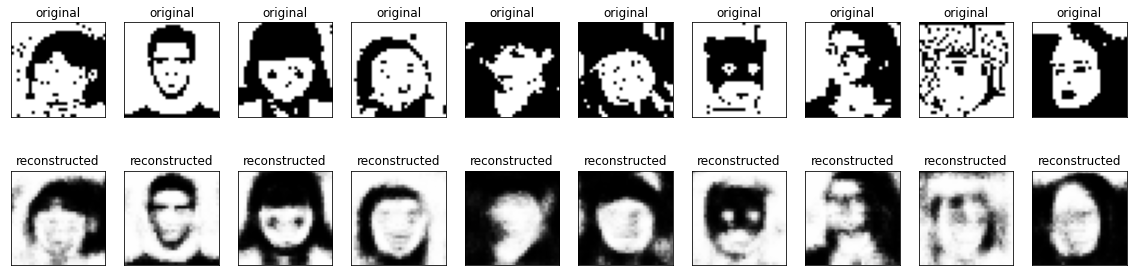

In [21]:
n = 10

plt.figure(figsize=(2 * 10, 5))

for i in range(10):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_images[i])
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i])
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()